In [1]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from PIL import Image

from glob import glob



from sklearn.model_selection import train_test_split

from sklearn import metrics



import cv2

import gc

import os



import tensorflow as tf

from tensorflow import keras

from keras import layers



import warnings

warnings.filterwarnings('ignore')


Importing Dataset

# Data Visualization

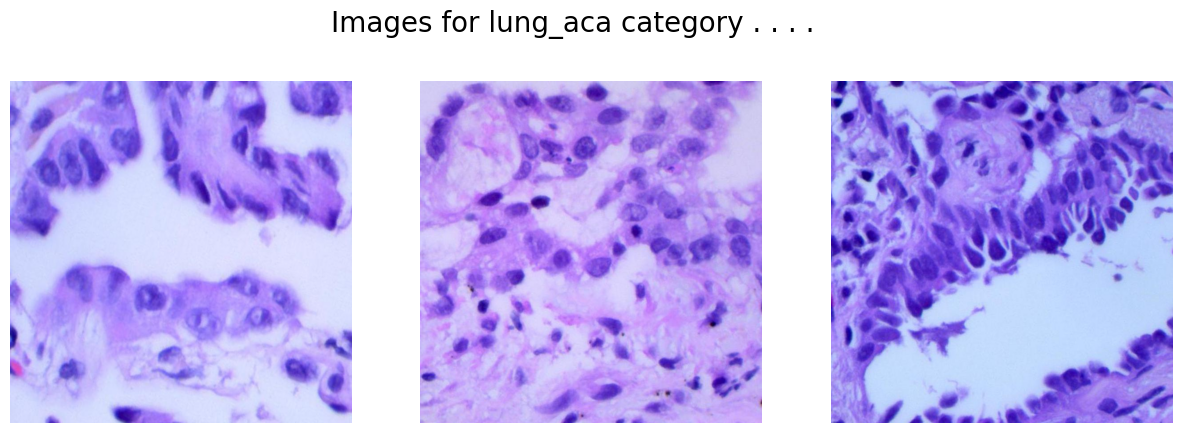

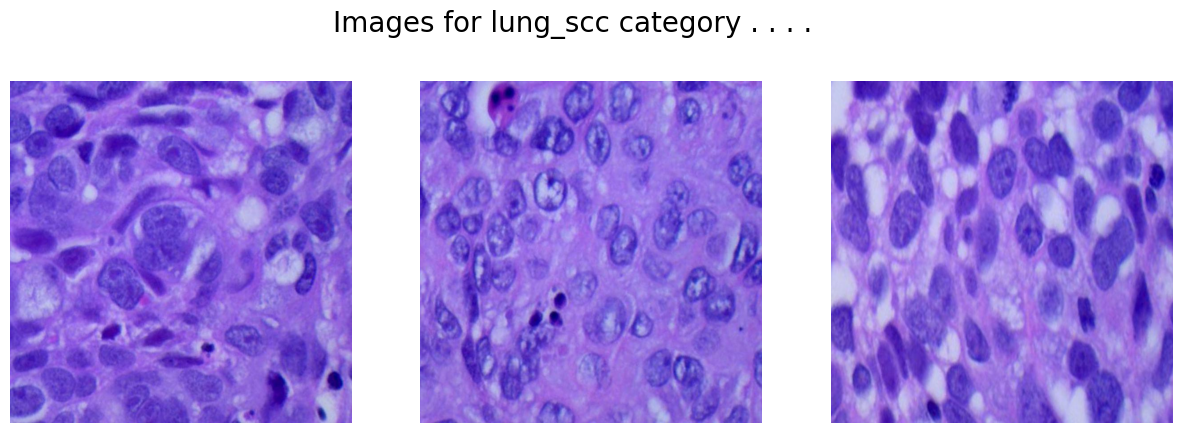

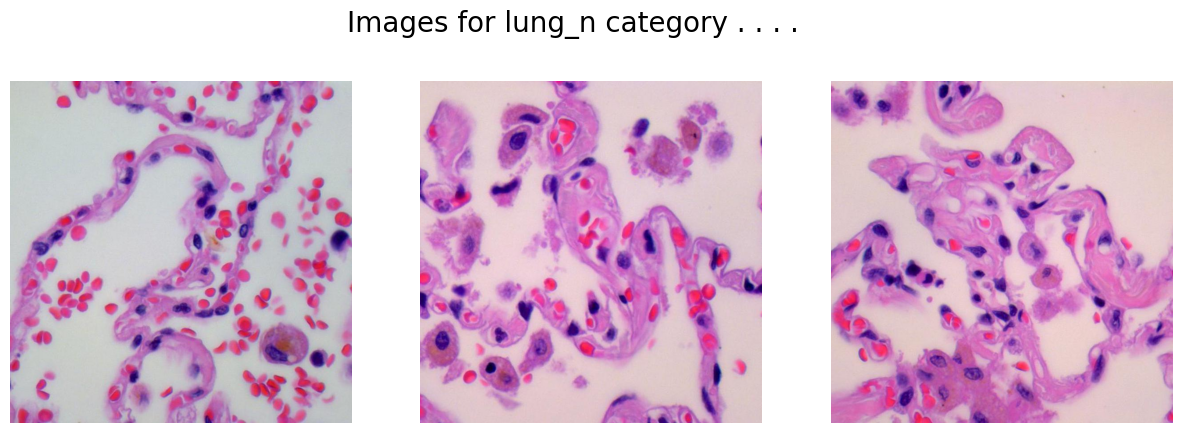

In [ ]:
# dataset link : https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
path = '../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'

classes = os.listdir(path)

classes



for cat in classes:

    image_dir = f'{path}/{cat}'

    images = os.listdir(image_dir)



    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)



    for i in range(3):

        k = np.random.randint(0, len(images))

        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))

        ax[i].imshow(img)

        ax[i].axis('off')

    plt.show()

# Data Preparation for Training

In [3]:
IMG_SIZE = 256

SPLIT = 0.2

EPOCHS = 10

BATCH_SIZE = 64

In [4]:
X = []

Y = []



for i, cat in enumerate(classes):

  images = glob(f'{path}/{cat}/*.jpeg')



  for image in images:

    img = cv2.imread(image)



    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))

    Y.append(i)



X = np.asarray(X)

one_hot_encoded_Y = pd.get_dummies(Y).values

In [6]:
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y,

                                                  test_size = SPLIT,

                                                  random_state = 2022)

print(X_train.shape, X_val.shape)

(12000, 256, 256, 3) (3000, 256, 256, 3)


# Model Development

In [7]:
model = keras.models.Sequential([

	layers.Conv2D(filters=32,

				kernel_size=(5, 5),

				activation='relu',

				input_shape=(IMG_SIZE,

							IMG_SIZE,

							3),

				padding='same'),

	layers.MaxPooling2D(2, 2),



	layers.Conv2D(filters=64,

				kernel_size=(3, 3),

				activation='relu',

				padding='same'),

	layers.MaxPooling2D(2, 2),



	layers.Conv2D(filters=128,

				kernel_size=(3, 3),

				activation='relu',

				padding='same'),

	layers.MaxPooling2D(2, 2),



	layers.Flatten(),

	layers.Dense(256, activation='relu'),

	layers.BatchNormalization(),

	layers.Dense(128, activation='relu'),

	layers.Dropout(0.3),

	layers.BatchNormalization(),

	layers.Dense(3, activation='softmax')

])

In [8]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    33,554,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,684,291 (128.50 MB)

 Trainable params: 33,683,523 (128.49 MB)

 Non-trainable params: 768 (3.00 KB)

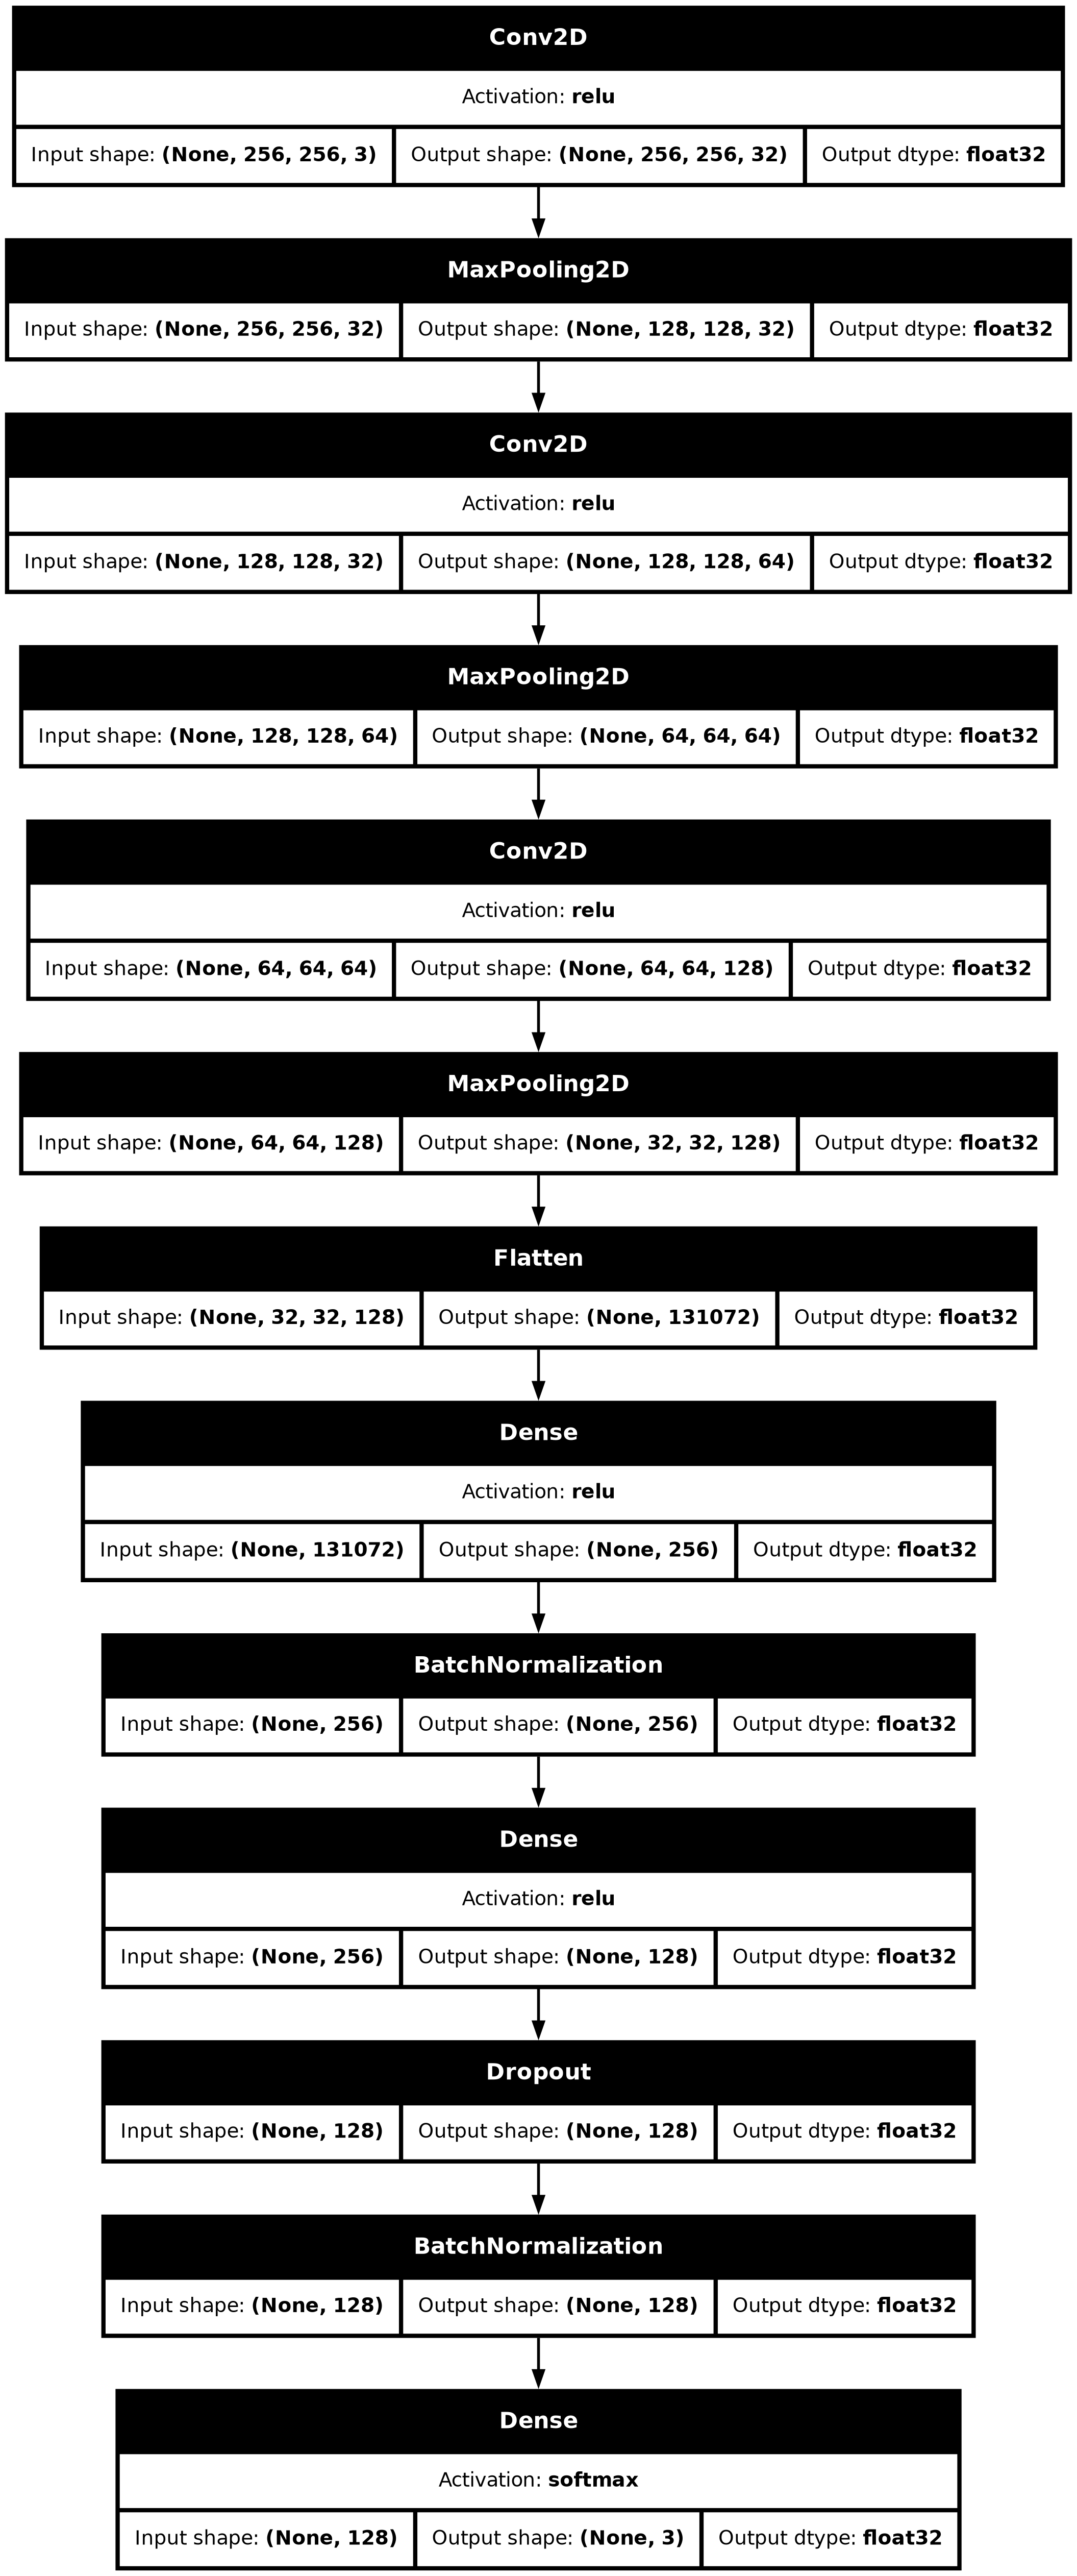

In [9]:
keras.utils.plot_model(

	model,

	show_shapes = True,

	show_dtype = True,

	show_layer_activations = True

)


In [12]:
model.compile(

    optimizer = 'adam',

    loss = 'categorical_crossentropy',

    metrics = ['accuracy']

)

Callback

In [21]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau





class myCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs={}):

    	if logs.get('val_accuracy') > 0.95:

    		print("\n Validation accuracy has reached upto 90% so, stopping further training.")

    		self.model.stop_training = True





es = EarlyStopping(patience=3,

				monitor='val_accuracy',

				restore_best_weights=True)



lr = ReduceLROnPlateau(monitor='val_loss',

					patience=2,

					factor=0.5,

					verbose=1)

history = model.fit(X_train, Y_train,

					validation_data = (X_val, Y_val),

					batch_size = BATCH_SIZE,

					epochs = EPOCHS,

					verbose = 1,

					callbacks = [es, lr, myCallback()])


Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 31s 167ms/step - accuracy: 0.9031 - loss: 0.2443 - val_accuracy: 0.3453 - val_loss: 18.2821 - learning_rate: 0.0010
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 26s 139ms/step - accuracy: 0.9247 - loss: 0.1991 - val_accuracy: 0.5267 - val_loss: 1.3640 - learning_rate: 0.0010
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 27s 146ms/step - accuracy: 0.9428 - loss: 0.1492 - val_accuracy: 0.6727 - val_loss: 1.7961 - learning_rate: 0.0010
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9611 - loss: 0.1053
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
188/188 ━━━━━━━━━━━━━━━━━━━━ 27s 143ms/step - accuracy: 0.9611 - loss: 0.1053 - val_accuracy: 0.3567 - val_loss: 16.0572 - learning_rate: 0.0010
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 27s 142ms/step - accuracy: 0.9759 - loss: 0.0725 - val_accuracy: 0.9293 - val_loss: 0.2077 - learning_rate: 5.0000e-04
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 27s 143ms/step - accuracy:

# Model Evaluation

In [22]:
Y_pred = model.predict(X_val)

Y_val = np.argmax(Y_val, axis=1)

Y_pred = np.argmax(Y_pred, axis=1)


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step


In [23]:
metrics.confusion_matrix(Y_val, Y_pred)


array([[ 923,   62,    2],
       [  40,  937,    0],
       [  14,    1, 1021]])

In [24]:
print(metrics.classification_report(Y_val, Y_pred,

									target_names=classes))


              precision    recall  f1-score   support

    lung_aca       0.94      0.94      0.94       987
    lung_scc       0.94      0.96      0.95       977
      lung_n       1.00      0.99      0.99      1036

    accuracy                           0.96      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.96      0.96      0.96      3000

